In [1]:
%matplotlib inline

import json
import os
import random

import tensorflow as tf

import matplotlib.pyplot as plt

from scipy.misc import imread

In [2]:
import sys
sys.path.append('./TensorBox')

from train import build_forward
from evaluate import add_rectangles

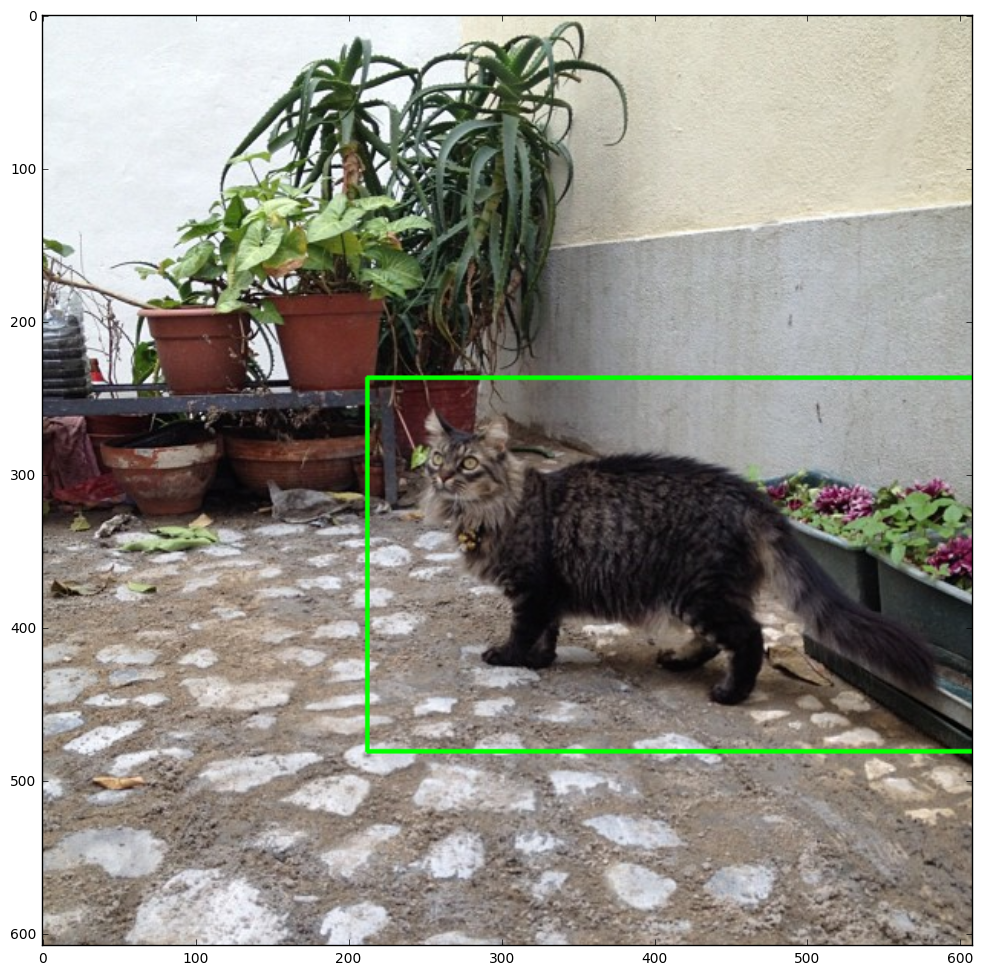

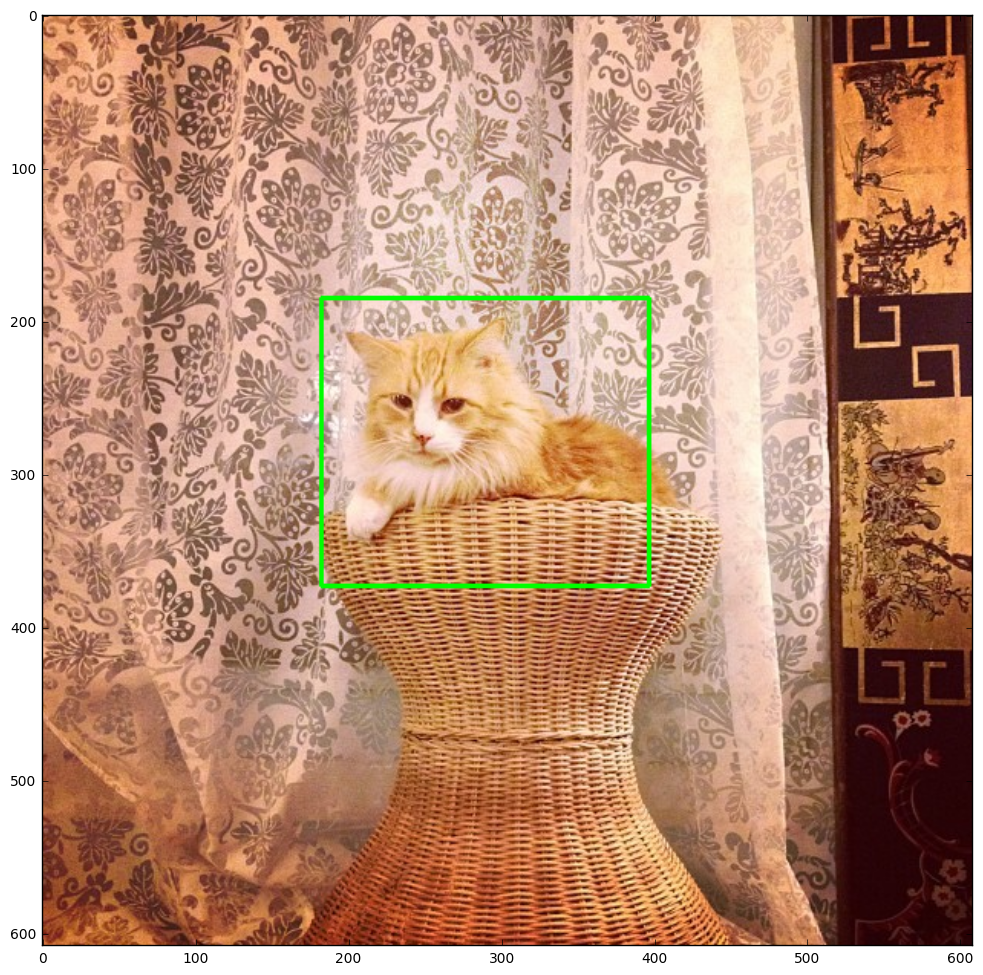

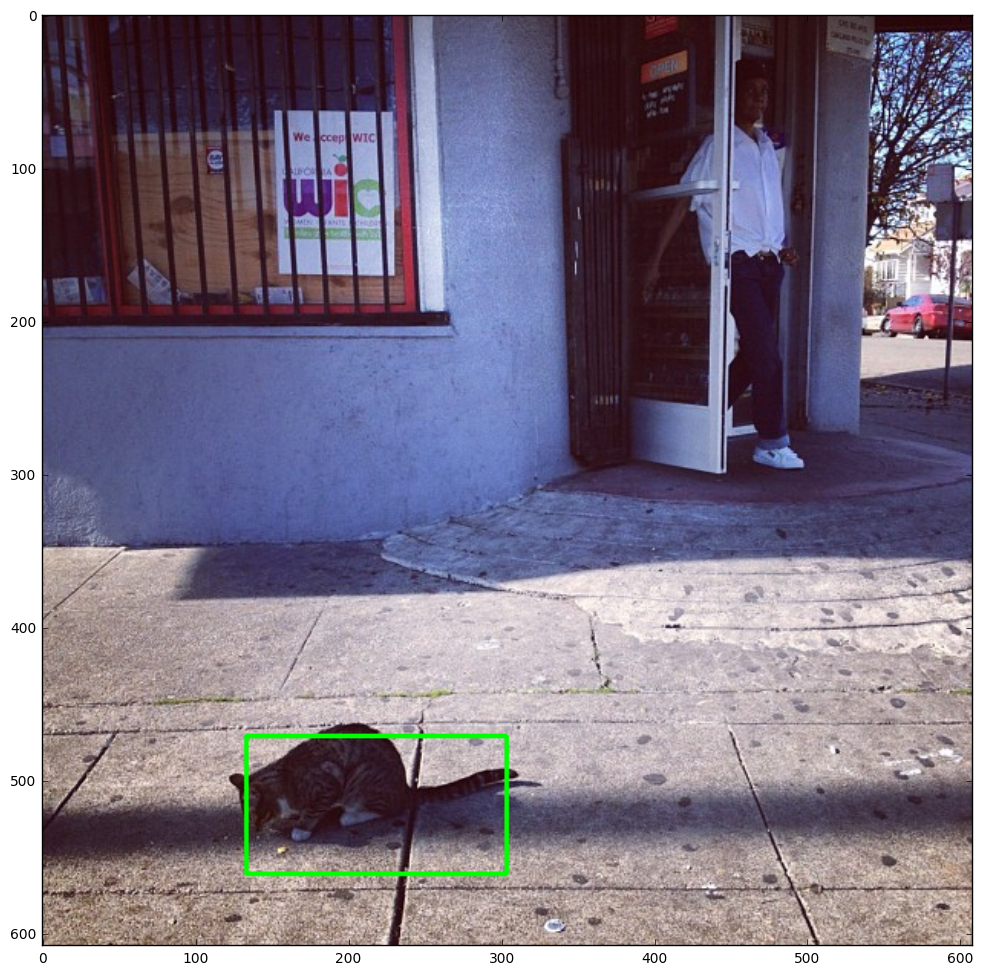

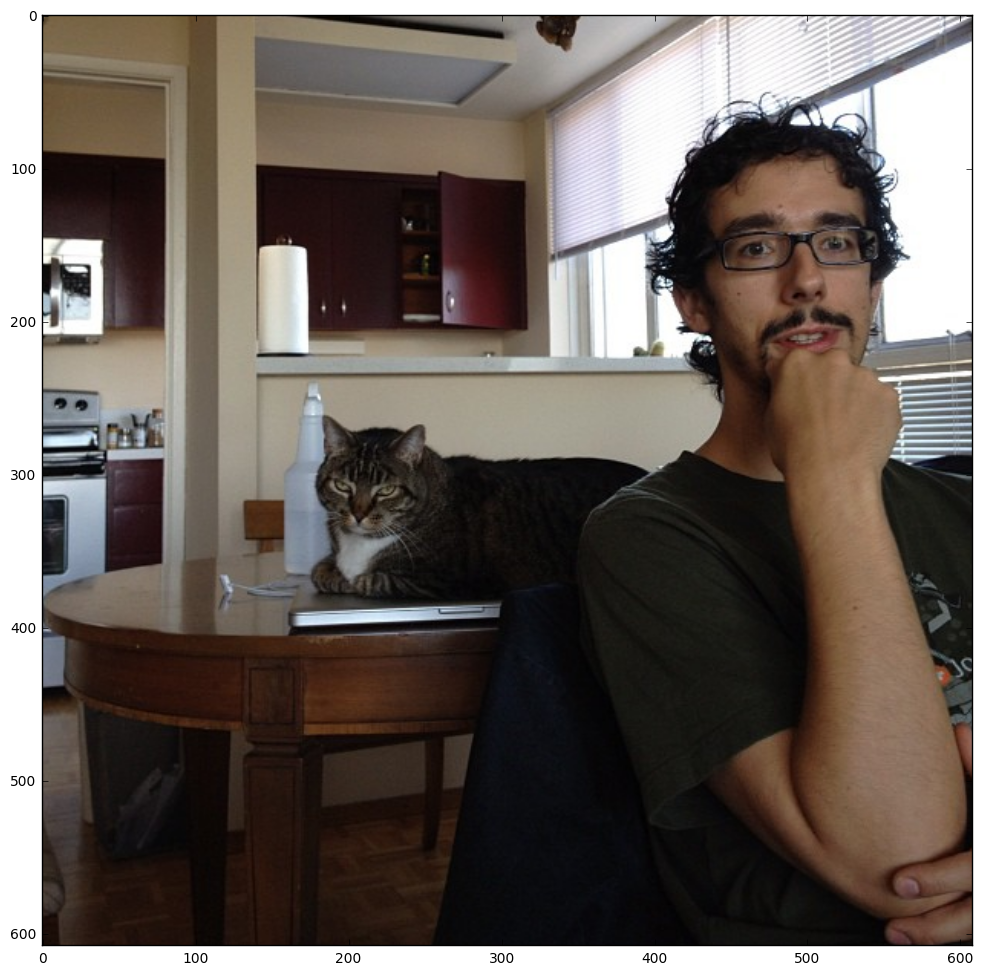

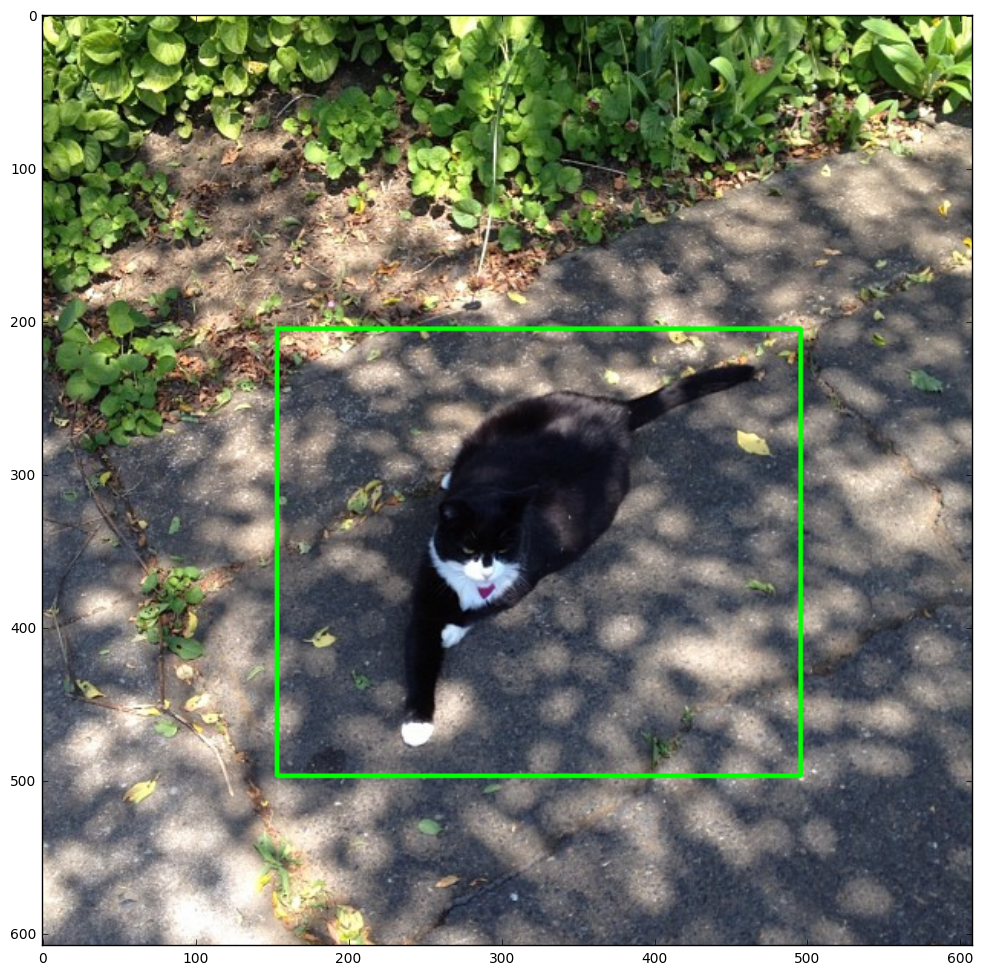

In [3]:
model_path = './save.ckpt-10000'
image_dir = './data/test'
hypes_file = './TensorBox/hypes/overfeat_rezoom.json'

with open(hypes_file, 'r') as f:
    H = json.load(f)

tf.reset_default_graph()
x_in = tf.placeholder(
    tf.float32, name='x_in', shape=[H['image_height'], H['image_width'], 3])

if H['use_rezoom']:
    pred_boxes, pred_logits, pred_confidences, pred_confs_deltas, pred_boxes_deltas = build_forward(
        H, tf.expand_dims(x_in, 0), 'test', reuse=None)
    grid_area = H['grid_height'] * H['grid_width']
    pred_confidences = tf.reshape(
        tf.nn.softmax(
            tf.reshape(pred_confs_deltas, [grid_area * H['rnn_len'], 2])),
        [grid_area, H['rnn_len'], 2])
    if H['reregress']:
        pred_boxes = pred_boxes + pred_boxes_deltas
else:
    pred_boxes, pred_logits, pred_confidences = build_forward(
        H, tf.expand_dims(x_in, 0), 'test', reuse=None)

saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    saver.restore(sess, model_path)

    images = os.listdir(image_dir)
    for i in range(5):
        fname = random.choice(images)
        path = os.path.join(image_dir, fname)
        img = imread(path)
        feed = {x_in: img}
        (np_pred_boxes, np_pred_confidences) = sess.run(
            [pred_boxes, pred_confidences], feed_dict=feed)
        new_img, rects = add_rectangles(
            H, [img],
            np_pred_confidences,
            np_pred_boxes,
            use_stitching=True,
            rnn_len=H['rnn_len'],
            min_conf=0.7,
            show_suppressed=False)

        fig = plt.figure(figsize=(12, 12))
        plt.imshow(new_img)